In [1]:
### Montlhy values / large scale

In [15]:
from pyproj import Proj, Transformer, transform, CRS
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
#import xesmf as xe
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import matplotlib.colors as colors
import glob
import os
import pandas as pd
import time
from itertools import groupby
from scipy.stats import linregress
from scipy import ndimage
from contrack import contrack
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import shapely
import shapely.ops as sops
import shapely.vectorized as sv

In [20]:
### some functions
def preprocess(ds):
    """
    Different variable names in time
    """
    if "valid_time" in ds:
        ds = ds.rename({"valid_time": "time"})
    if "valid_time_bnds" in ds:
        ds = ds.rename({"valid_time_bnds": "time_bnds"})
    if "pressure_level" in ds:    
        ds = ds.rename({"pressure_level": "level"})    
    return xr.decode_cf(ds)  # makes time usable if units are valid
def plot_three_maps(bias, da_4years, da_era5_4years,
                    abs_levels=np.arange(-40, 40, 4),
                    abs_cmap='RdBu_r',
                    bias_cmap='RdBu_r',
                    titles=('Bias', '4-year mean (ICON)', '13-year mean (ERA5)')):
    """
    Plot three global maps on Robinson projection:
      1) bias (diverging, centered at 0)
      2) da_4years (absolute field, shared scale with #3)
      3) da_era5_4years (absolute field, shared scale with #2)

    Parameters
    ----------
    bias, da_4years, da_era5_4years : xarray.DataArray
        Lat/lon gridded fields in PlateCarree coordinates.
    abs_levels : 1D array-like
        Contourf levels for the absolute fields (2 & 3).
    abs_cmap : str
        Colormap for the absolute fields.
    bias_cmap : str
        Colormap for the bias field.
    titles : tuple of str
        Titles for (bias, da_4years, da_era5_4years).
    """
    proj_map = ccrs.Robinson()
    data_crs = ccrs.PlateCarree()

    fig, axes = plt.subplots(3, 1, figsize=(5, 6), dpi=100,
                             subplot_kw={'projection': proj_map})

    # ---- Absolute fields share the same normalization ----
    abs_norm = colors.BoundaryNorm(abs_levels, ncolors=plt.get_cmap(abs_cmap).N, clip=True)

    # ---- Bias uses a centered diverging norm ----
    vmax = np.nanpercentile(np.abs(bias.values), 99)  # robust symmetric range
    if not np.isfinite(vmax) or vmax == 0:
        vmax = np.nanmax(np.abs(bias.values)) if np.isfinite(np.nanmax(np.abs(bias.values))) else 1.0
    bias_norm = colors.TwoSlopeNorm(vmin=-vmax, vcenter=0.0, vmax=vmax)

    # 3) da_era5_4years
    h2 = da_era5_4years.plot(ax=axes[0],
                             transform=data_crs,
                             cmap=abs_cmap,
                             levels=abs_levels,
                             norm=abs_norm,
                             cbar_kwargs={'shrink': 0.6, 'label': 'U (m/s)'}
                             )
    axes[0].set_title(titles[0])
    axes[0].coastlines()

    # 2) da_4years
    h1 = da_4years.plot(ax=axes[1],
                        transform=data_crs,
                        cmap=abs_cmap,
                        levels=abs_levels,
                        norm=abs_norm,
                        cbar_kwargs={'shrink': 0.6, 'label': 'U (m/s)'}
                        )
    axes[1].set_title(titles[1])
    axes[1].coastlines()
    
    # 1) Bias
    h0 = bias.plot(ax=axes[2],
                   transform=data_crs,
                   cmap=bias_cmap,
                   norm=bias_norm,
                   cbar_kwargs={'shrink': 0.6, 'label': 'Bias (m/s)'}
                   )
    axes[2].set_title(titles[2])
    axes[2].coastlines()

    # A little breathing room
    plt.tight_layout()
    return fig, (h0, h1, h2)

In [14]:
uwind_era5=xr.open_mfdataset('/capstor/scratch/cscs/edolores/OBS/ERA5/U500/u500_mon*',preprocess=preprocess)['u'].squeeze()
uwind_era5

uwind_icon=xr.open_mfdataset('/capstor/scratch/cscs/edolores/EXCLAIM/ICON_2KM/U500/u500_day*')['u'].squeeze()
uwind_icon=uwind_icon.sel(lat=slice(0,90))
uwind_icon

<xarray.DataArray 'u' (time: 1534, lat: 181, lon: 720)> Size: 800MB
dask.array<getitem, shape=(1534, 181, 720), dtype=float32, chunksize=(1, 181, 720), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 12kB 2020-01-20T10:30:00 ... 2024-04-01
  * lon      (lon) float32 3kB -180.0 -179.5 -179.0 -178.5 ... 178.5 179.0 179.5
  * lat      (lat) float32 724B 0.0 0.5 1.0 1.5 2.0 ... 88.0 88.5 89.0 89.5 90.0
    plev     float64 8B 5e+04
Attributes:
    standard_name:  eastward_wind
    long_name:      Zonal wind
    units:          m s-1
    param:          2.2.0
    cell_methods:   time: mean

In [16]:
### mean
muwind_era5=uwind_era5.mean(dim='time')
muwind_icon=uwind_icon.mean(dim='time')
### BIAS of 4 years
bias= muwind_icon - muwind_era5

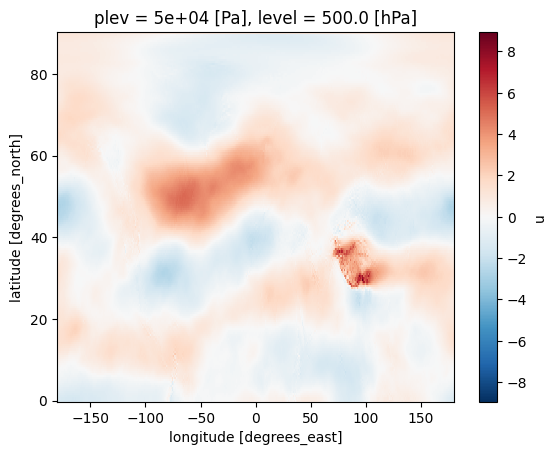

In [18]:
bias.plot()

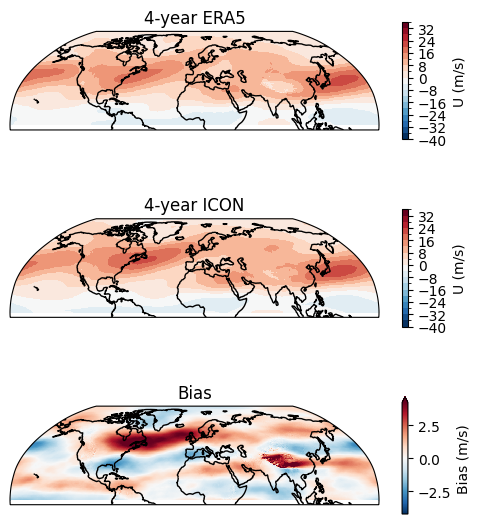

In [21]:
# ---
fig, _ = plot_three_maps(bias, muwind_icon, muwind_era5,abs_levels=np.arange(-40, 40, 4), titles=('4-year ERA5','4-year ICON','Bias'))